In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import cvxpy

In [2]:
df = pd.read_csv('closing_prices.csv')
data = df.to_numpy() # if you prefer working with np array

In [3]:
n = data.shape[1]
returns = (data[1:] - data[:-1]) / data[:-1]
mu = np.mean(returns, axis=0)
C = np.cov(returns, rowvar=False)
C_inv = np.linalg.inv(C)

## 1. Monte-Carlo

In [4]:
def compute_risk_return(w):
    var = w.T @ C @ w
    ret = w.T @ mu
    return np.sqrt(var), ret

In [5]:
num_MC = 100000
weights_mc, risks_mc, rets_mc = [], [], []
for _ in range(num_MC):
    w = np.random.random(n)
    w /= w.sum()
    risk, ret = compute_risk_return(w)
    weights_mc.append(w)
    risks_mc.append(risk)
    rets_mc.append(ret)

## 2. Analytical expression

In [6]:
def compute_weights(mu_p):
    ones = np.ones(n)
    a = ones.T @ C_inv @ ones
    b = ones.T @ C_inv @ mu
    c = mu.T @ C_inv @ mu
    d = a * c - b ** 2
    lambda1 = (c - b * mu_p) / d
    lambda2 = (a * mu_p - b) / d
    w = C_inv @ (lambda1 * ones + lambda2 * mu)
    return w

In [7]:
possible_returns = np.linspace(-0.0006, 0.0004, 1000)
weights, risks, rets = [], [], []
for rp in possible_returns:
    w = compute_weights(rp)
    risk, ret = compute_risk_return(w)
    weights.append(w)
    risks.append(risk)
    rets.append(ret)


## 3. Minimal risk portfolio

In [8]:
idx_min = np.argmin(risks)
risk_min, ret_min = compute_risk_return(weights[idx_min])
print('Portfolio with minimum volatiliy')
print(f'Volatility = {100 * risk_min: .02f}%')
print(f'Expected return = {100 * ret_min: .03f}%')
print('Weights = ' + ', '.join([f'{w: .02f}' for w in weights[idx_min]]))

Portfolio with minimum volatiliy
Volatility =  0.61%
Expected return = -0.003%
Weights =  0.34,  0.03,  0.08,  0.19,  0.08,  0.14,  0.13


## Plot

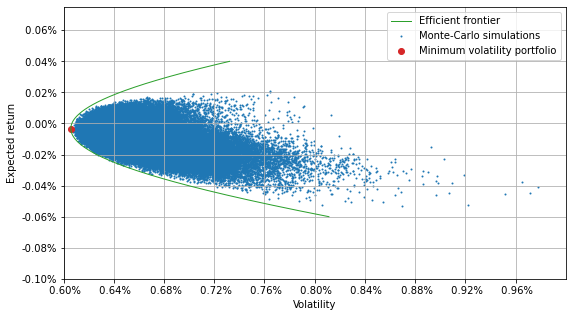

In [9]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(risks, rets, lw=1, c='tab:green', label='Efficient frontier')
ax.scatter(risks_mc, rets_mc, s=1, c='tab:blue', label='Monte-Carlo simulations')
ax.scatter(risks[idx_min], rets[idx_min], c='tab:red', label='Minimum volatility portfolio')
ax.set(xlabel='Volatility', ylabel='Expected return',
       xlim=(0.006, 0.01), xticks=np.arange(0.006, 0.01, 0.0004), xticklabels=[f'{x * 100: .02f}%' for x in np.arange(0.006, 0.01, 0.0004)],
       ylim=(-0.001, 0.00075), yticks=np.arange(-0.001, 0.00075, 0.0002), yticklabels=[f'{x * 100: .02f}%' for x in np.arange(-0.001, 0.00075, 0.0002)])
ax.grid('on')
ax.legend()
plt.show()

# 4 Optimal Portfolio under No-Short Selling Constraints


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

df = pd.read_csv('closing_prices.csv', index_col=0, parse_dates=True)

# compute daily log returns
returns = np.log(df / df.shift(1)).dropna()
mu = returns.mean().values          # expected returns for each stock
C = returns.cov().values            # covariance matrix

n = len(mu)  # number of stocks

# define target range for portfolio returns (unconstrained and constrained)
mu_min = np.min(mu)
mu_max = np.max(mu)
target_returns = np.linspace(mu_min, mu_max, 50)

def unconstrained_weights(mu, C, mu_p):
    ones = np.ones(n)
    C_inv = np.linalg.inv(C)
    a = ones.T @ C_inv @ ones
    b = ones.T @ C_inv @ mu
    c = mu.T @ C_inv @ mu
    d = a * c - b**2
    lambda1 = (c - b * mu_p) / d
    lambda2 = (a * mu_p - b) / d
    w = C_inv @ (lambda1 * ones + lambda2 * mu)
    return w

unconstrained_risks = []
unconstrained_returns = []
for mu_p in target_returns:
    w = unconstrained_weights(mu, C, mu_p)
    port_return = w @ mu
    port_risk = np.sqrt(w.T @ C @ w)
    unconstrained_returns.append(port_return)
    unconstrained_risks.append(port_risk)

# solving constrained problem (no short selling)
def solve_constrained(mu, C, mu_p):
    # optimization variable
    w = cp.Variable(n)
    # minimize portfolio variance
    portfolio_variance = cp.quad_form(w, C)
    objective = cp.Minimize(portfolio_variance)
    # constraints: sum of weights equals 1, portfolio return equals target, weights >= 0
    constraints = [
        cp.sum(w) == 1,
        mu @ w == mu_p,
        w >= 0
    ]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return w.value, np.sqrt(prob.value)

constrained_risks = []
constrained_returns = []
for mu_p in target_returns:
    try:
        w_con, risk = solve_constrained(mu, C, mu_p)
        port_return = w_con @ mu
        constrained_returns.append(port_return)
        constrained_risks.append(risk)
    except Exception as e:
        print(f"Infeasible for target return {mu_p}: {e}")

Infeasible for target return -0.0008285086457153716: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
Infeasible for target return 0.00017224961624834193: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
Infeasible for target return 0.00019400523063885743: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)


/home/bini/miniconda3/envs/test_gpu/lib/python3.8/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


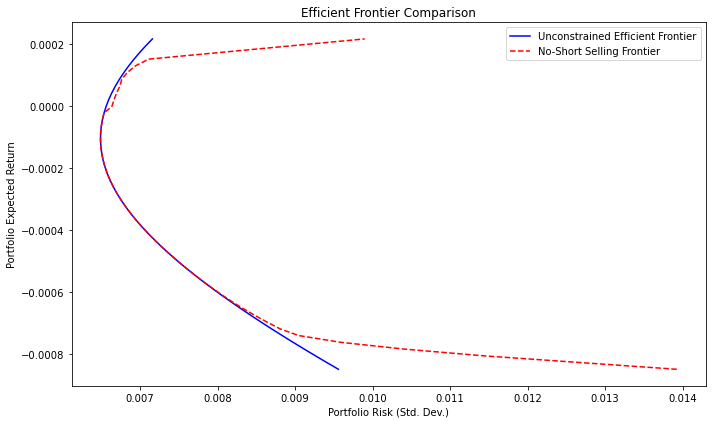

No-short selling minimal risk portfolio weights:
[0.03105553 0.13952601 0.2309609  0.21472521 0.21323796 0.1704944 ]
Minimum risk: 0.0065, Expected return: -0.0001


In [12]:
plt.figure(figsize=(10, 6))
plt.plot(unconstrained_risks, unconstrained_returns, 'b-', label='Unconstrained Efficient Frontier')
plt.plot(constrained_risks, constrained_returns, 'r--', label='No-Short Selling Frontier')
plt.xlabel('Portfolio Risk (Std. Dev.)')
plt.ylabel('Portfolio Expected Return')
plt.title('Efficient Frontier Comparison')
plt.legend()
plt.tight_layout()
plt.show()

# minimal risk portfolio under no-short selling constraint
# we can minimize the variance without a return constraint.
w_min = cp.Variable(n)
objective_min = cp.Minimize(cp.quad_form(w_min, C))
constraints_min = [cp.sum(w_min) == 1, w_min >= 0]
prob_min = cp.Problem(objective_min, constraints_min)
prob_min.solve()
min_risk_portfolio = w_min.value
min_risk = np.sqrt(prob_min.value)
min_return = min_risk_portfolio @ mu

print("No-short selling minimal risk portfolio weights:")
print(min_risk_portfolio)
print(f"Minimum risk: {min_risk:.4f}, Expected return: {min_return:.4f}")